## Hand Digits

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics

from scipy.ndimage.interpolation import rotate

from sklearn.datasets import load_digits

#### 1. Read data

In [2]:
data = load_digits()

In [3]:
# Display the description on the data.
print(data['DESCR'])

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [4]:
X = data['data']
Y = data['target']

X.shape, Y.shape

((1797, 64), (1797,))

In [5]:
# Visualize data
def show_data(X, Y, n, angle=0):
    print(Y[n])
    image_matrix = X[n,:].reshape((8,8))                                        # Reshape from 1D to 2D matrix.
    image_matrix = rotate(image_matrix, angle, cval=0.01, reshape=False)        # Rotate if wanted.       
    plt.imshow(image_matrix, cmap='Greys',interpolation='None')
    plt.show()


5


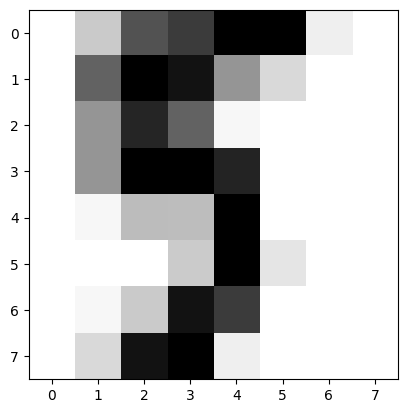

In [6]:
show_data(X, Y, 15)

In [7]:
print(X[15])

[ 0.  5. 12. 13. 16. 16.  2.  0.  0. 11. 16. 15.  8.  4.  0.  0.  0.  8.
 14. 11.  1.  0.  0.  0.  0.  8. 16. 16. 14.  0.  0.  0.  0.  1.  6.  6.
 16.  0.  0.  0.  0.  0.  0.  5. 16.  3.  0.  0.  0.  1.  5. 15. 13.  0.
  0.  0.  0.  4. 15. 16.  2.  0.  0.  0.]


#### 2. Data pre-processing

In [8]:
# Min-Max scaling to the whole dataset.
X_min = X.min()
X_max = X.max()
X_range = X_max - X_min
X = (X - X_min)/X_range

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=10)

#### 3. Optimizing Hyperparameters

In [15]:
model_params = {
    'knn': {
        'model': DecisionTreeClassifier(),
        'params': {
            'max_depth': np.arange(2, 15, 2), 
            'min_samples_leaf': np.arange(2, 31, 4), 
            'max_leaf_nodes': np.arange(2,31,2)
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': np.arange(20, 30, 2),
            'max_depth': np.arange(2, 10, 2),
            'min_samples_leaf': np.arange(10, 17, 2)
        }
    },
}

In [17]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import pandas as pd
scores = []

for model_name, mp in model_params.items():
    print('Running', model_name)
    clf = RandomizedSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X, Y)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

df2 = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])
df2

Running knn
Running random_forest


,model,best_score,best_params
0,knn,0.734048,"{'min_samples_leaf': 22, 'max_leaf_nodes': 24,..."
1,random_forest,0.899847,"{'n_estimators': 24, 'min_samples_leaf': 14, '..."


#### 4. Classification with AdaBoost

In [18]:
n_estimators_grid = np.arange(50, 81, 4)
parameters = {'n_estimators': n_estimators_grid}
AB = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=9), learning_rate=0.01)      # Instantiate an estimator.
gridCV = GridSearchCV(AB, param_grid=parameters, cv=10, n_jobs = -1)
gridCV.fit(X_train, Y_train)
best_n_estim = gridCV.best_params_['n_estimators']

In [19]:
print("AdaBoost best n estimator : " + str(best_n_estim))

AdaBoost best n estimator : 78


In [20]:
AB_best = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=9),n_estimators=best_n_estim,learning_rate=0.01, random_state=123)
AB_best.fit(X_train, Y_train)
Y_pred = AB_best.predict(X_test)
print( "AdaBoost best accuracy : " + str(np.round(metrics.accuracy_score(Y_test,Y_pred),3)))

AdaBoost best accuracy : 0.93
